In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import regex as re

In [2]:
df = pd.read_excel (r'punjabi_modelDataset.xlsx', sheet_name='Sheet1')
print(df.head())

   sent_index    word    tag
0           0  ਸੰਯੁਕਤ  B-LOC
1           0  ਰਾਸ਼ਟਰ      O
2           0      ਦੀ  I-LOC
3           0  ਸਥਾਪਨਾ      O
4           0      24      O


In [3]:
df.drop(df[df['word'].str.match(r'[A-Za-z0-9]\w+') == True].index, inplace = True)

In [4]:
len(df)

51085

In [5]:
def delete_russianchar():
    char_loc = [re.findall(r'\p{IsCyrillic}', str(x)) for x in df['word']]
    idx=0
    char_index = []
    for item in char_loc:
        if len(item) is not 0:
            char_index.append(idx)
        idx=idx+1
    
    #print(df.iloc[char_index])
    df.drop(df.index[char_index], inplace = True)
    print(len(df))

In [6]:
delete_russianchar()

51053


In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(df)

In [9]:
sentences = getter.sentences

In [10]:
print(sentences[10])

[('ਦਾਦਰਾ', 'O'), ('ਅਤੇ', 'I-ORG'), ('ਨਗਰ', 'I-LOC'), ('ਹਵੇਲੀ', 'I-LOC'), ('ਭਾਰਤ', 'I-ORG'), ('ਦੇ', 'I-ORG'), ('7', 'B-LOC'), ('ਕੇਂਦਰੀ', 'O'), ('ਸ਼ਾਸ਼ਤ', 'O'), ('ਪ੍ਰਦੇਸਾਂ', 'O'), ('ਵਿੱਚੋਂ', 'O'), ('ਇੱਕ', 'O'), ('ਹੈ', 'O'), ('।', 'O')]


In [11]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 573


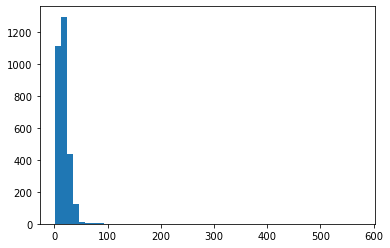

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
words = list(set(df["word"].values))
words.append("end_padding")
n_words = len(words)
n_words

7061

In [14]:
tags = list(set(df["tag"].values))
n_tags = len(tags)
n_tags

7

In [15]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
print(type(word2idx))

<class 'dict'>


In [17]:
dict_items = word2idx.items()
first_5 = list(dict_items)[:5]
print(first_5)

[('ਗੋਦਾਵਰੀ', 0), ('ਅਲੀਬਾਬਾ', 1), ('ਕਰਣ', 2), ('ਉੱਘੇ', 3), ('ਕਿਰਤ', 4)]


In [18]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [19]:
X = pad_sequences(maxlen=150, sequences=X, padding="post",value=n_words - 1)

In [20]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=150, sequences=y, padding="post", value=tag2idx["O"])

In [21]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [24]:
input = Input(shape=(150,))
model = Embedding(input_dim=n_words, output_dim=150, input_length=150)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [25]:
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)

C:\Users\rosha\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1911 samples, validate on 478 samples
Epoch 1/10
1911/1911 [==============================] - 36s 19ms/step - loss: 0.3041 - accuracy: 0.9433 - val_loss: 0.1400 - val_accuracy: 0.9588
Epoch 2/10
1911/1911 [==============================] - 41s 22ms/step - loss: 0.1294 - accuracy: 0.9595 - val_loss: 0.1222 - val_accuracy: 0.9588
Epoch 3/10
1911/1911 [==============================] - 35s 18ms/step - loss: 0.1079 - accuracy: 0.9632 - val_loss: 0.0925 - val_accuracy: 0.9699
Epoch 4/10
1911/1911 [==============================] - 26s 14ms/step - loss: 0.0736 - accuracy: 0.9759 - val_loss: 0.0601 - val_accuracy: 0.9843
Epoch 5/10
1911/1911 [==============================] - 28s 15ms/step - loss: 0.0454 - accuracy: 0.9882 - val_loss: 0.0390 - val_accuracy: 0.9913
Epoch 6/10
1911/1911 [==============================] - 27s 14ms/step - loss: 0.0271 - accuracy: 0.9938 - val_loss: 0.0255 - val_accuracy: 0.9937
Epoch 7/10
1911/1911 [==============================] - 27s 14ms/step - loss:

In [27]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
ਜਲਗਾਹਾਂ       : O
ਜ਼ਮੀਨੀ        : O
ਅਤੇ           : I-ORG
ਜਲ            : O
ਪ੍ਰਣਾਲੀਆਂ     : O
ਵਿਚਕਾਰ        : O
ਉਹ            : O
ਜਗ੍ਹਾ         : O
ਹਨ            : O
ਜਿੱਥੇ         : O
ਪਾਣੀ          : O
ਦਾ            : O
ਪੱਧਰ          : O
ਧਰਤੀ          : O
ਦੀ            : I-LOC
ਸਤ੍ਹਾ         : O
ਦੇ            : I-ORG
ਨੇੜੇ          : O
ਹੁੰਦਾ         : O
ਹੈ            : O
ਜਾਂ           : O
ਪਾਣੀ          : O
ਘੱਟ           : B-ORG
ਡੂੰਘਾ         : O
ਹੁੰਦਾ         : O
ਹੈ            : O
।             : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
e

In [28]:
pred = []
for i in range(len(y_test)):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

In [29]:
pred_temp = [x[0] for x in pred]
y_temp = []

In [30]:
for i in range(len(y_test)):
    y_temp.append(np.array([np.where(y_test[i][j]==1)[0][0] for j in range(len(y_test[i]))]))

In [31]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [32]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)


Confusion Matrix and Classification Report

 AxesSubplot(0.125,0.125;0.62x0.755)

               precision    recall  f1-score   support

       B-LOC       1.00      0.94      0.97       496
       B-ORG       0.96      0.91      0.93       215
       B-PER       0.89      0.78      0.83       233
       I-PER       1.00      0.96      0.98       727
       I-ORG       1.00      0.98      0.99      1374
           O       1.00      1.00      1.00     86097
       I-LOC       1.00      0.97      0.98       558

    accuracy                           1.00     89700
   macro avg       0.98      0.93      0.96     89700
weighted avg       1.00      1.00      1.00     89700



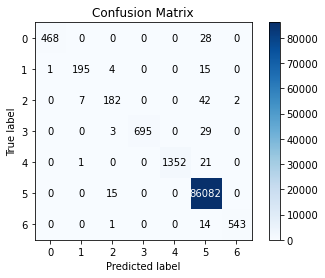

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
print('\nConfusion Matrix and Classification Report')
print('\n', skplt.metrics.plot_confusion_matrix(actual, predicted))
print('\n', classification_report(actual, predicted, target_names=tags))

In [34]:
import pickle
pkl_filename = "punjabi_ner_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [35]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

C:\Users\rosha\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
